In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import sys
import time
import tqdm
import numpy as np
import pandas as pd
tqdm.tqdm.pandas()
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


/home/alper/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_csv("/mnt/d/work2/turkish-news-classification/data/cleaned.csv", usecols=["Haber Gövdesi Cleaned", "Sınıf"])
df = df.dropna()
df = df.reset_index(drop=True)

In [3]:
X = df["Haber Gövdesi Cleaned"]
y = df["Sınıf"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [5]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [6]:
xgb = XGBClassifier(device="cuda")
xgb_tfidf_train_start = time.time()
xgb.fit(X_train_tfidf, y_train)
xgb_tfidf_train_time = time.time() - xgb_tfidf_train_start
print(f"TFIDF + XGB Train Time = {xgb_tfidf_train_time:.4f}")

TFIDF + XGB Train Time = 2254.2583


In [7]:
xgb_tfidf_pred_train = xgb.predict(X_train_tfidf)
xgb_tfidf_test_start = time.time()
xgb_tfidf_pred_test = xgb.predict(X_test_tfidf)
xgb_tfidf_test_time = time.time() - xgb_tfidf_test_start

In [8]:
xgb_tfidf_train_score = accuracy_score(xgb_tfidf_pred_train, y_train)
xgb_tfidf_test_score = accuracy_score(xgb_tfidf_pred_test, y_test)
print(f"TFIDF + XGB Train Score = {xgb_tfidf_train_score * 100:.4f}%")
print(f"TFIDF + XGB Test Score = {xgb_tfidf_test_score * 100:.4f}%")
print(f"TFIDF + XGB Test Time = {xgb_tfidf_test_time:.4f}")

TFIDF + XGB Train Score = 39.2797%
TFIDF + XGB Test Score = 39.2792%
TFIDF + XGB Test Time = 0.5627


In [9]:
xgb_tfidf_precision_score = precision_score(y_test, xgb_tfidf_pred_test, average='macro')
xgb_tfidf_f1_score = f1_score(y_test, xgb_tfidf_pred_test, average='macro')
xgb_tfidf_recall_score = recall_score(y_test, xgb_tfidf_pred_test, average='macro')
xgb_tfidf_accuracy_score = accuracy_score(y_test, xgb_tfidf_pred_test)

print(f"TFIDF + XGB Precision Score = {xgb_tfidf_precision_score * 100:.4f}%")
print(f"TFIDF + XGB F1 Score = {xgb_tfidf_f1_score * 100:.4f}%")
print(f"TFIDF + XGB Recall Score = {xgb_tfidf_recall_score * 100:.4f}%")
print(f"TFIDF + XGB Accuracy Score = {xgb_tfidf_accuracy_score * 100:.4f}%")

TFIDF + XGB Precision Score = 15.1746%
TFIDF + XGB F1 Score = 6.5688%
TFIDF + XGB Recall Score = 11.1087%
TFIDF + XGB Accuracy Score = 39.2792%


In [10]:
print(classification_report(y_test, xgb_tfidf_pred_test, target_names=le.classes_))

                 precision    recall  f1-score   support

Bilim-Teknoloji       0.00      0.00      0.00      3051
 Finans-Ekonomi       0.00      0.00      0.00      3668
   Kültür-Sanat       0.00      0.00      0.00      4663
        Magazin       0.41      1.00      0.58     31592
         Sağlık       0.01      0.00      0.00      4786
        Siyaset       0.94      0.00      0.00     14726
           Spor       0.00      0.00      0.00     13144
         Turizm       0.00      0.00      0.00      2966
          Çevre       0.00      0.00      0.00      1561

       accuracy                           0.39     80157
      macro avg       0.15      0.11      0.07     80157
   weighted avg       0.34      0.39      0.23     80157



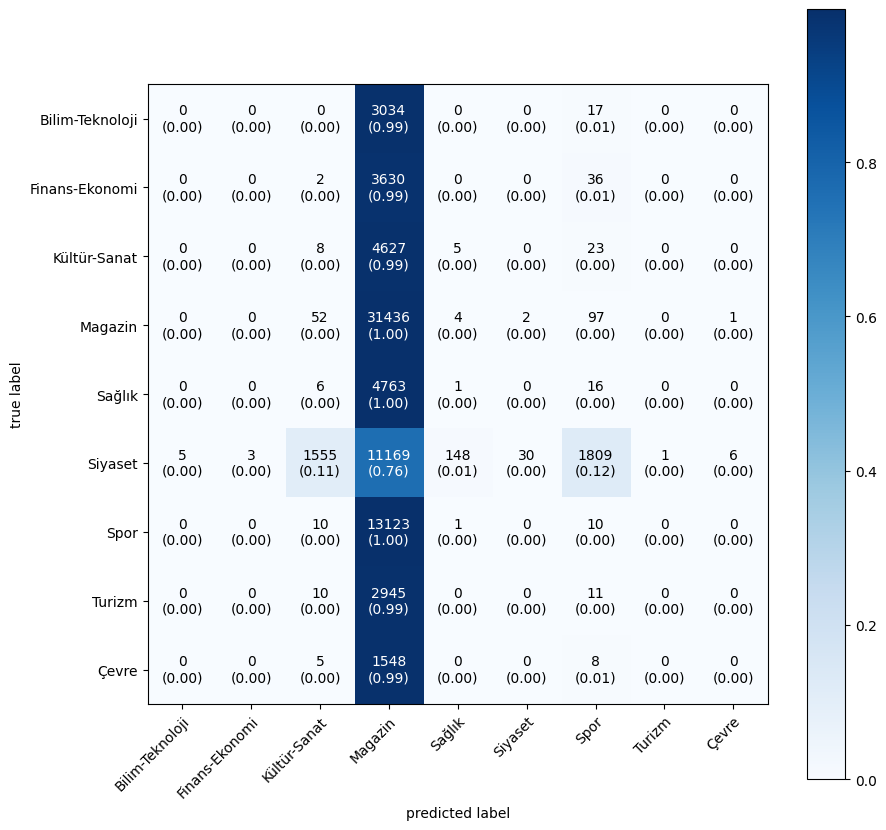

In [11]:
xgb_tfidf_cm = confusion_matrix(y_test, xgb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=xgb_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_, figsize=(10, 10))
plt.savefig("./output/xgb_tfidf.png")
plt.show()